In [ ]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba

import numpy as np

### **The polynomial case** 

In this experiement, $x_0$ follows a Gaussian distribution ($x_0 \sim \mathcal{N}(\mu_{0}, \Sigma_{0})$), and the system is polynomial following XXX.

We aim to compute GMM approximations $\hat{p}(x_t)$ for $5$ time steps, as well as bounds on their TV distances to the true distributions $p(x_t)$.

**Numerical note**: The theory related to this experiement does NOT demand that those Gaussians should have uncorrelated components. However, our current code implementation does assume that.

##### 1) Defining system parameters

In [ ]:
METHOD = 'polynomial'

h = 0.05

params = [h]

In [ ]:
#Initial distribution
sigma = 0.002

mean_initial_state = np.array([1, 1])
var_initial_state = np.array([sigma, sigma]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Noise structure
sigma_noise = 0.01

mean_noise = [0, 0]
var_noise = np.array([sigma_noise, sigma_noise/2]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Steps ahead for prediction
n_steps_ahead = 7

In [ ]:
unbounded_region = np.array([[np.inf, np.inf], [np.inf, np.inf]]) #a representation choice for the unbounded region

In [ ]:
colors = ['Purples', 'Blues', 'Oranges', 'YlOrBr', 'YlOrRd', 
          'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 
          'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

##### 2) Monte Carlo simulation of the system

We run a MC simulation for the system above in order to understand its (probabilistic) behavior.

Note: We also add a representation for an unsafe set (red square) which will later motivate safety discussions.

In [ ]:
barriers_list = barriers.createBarrier(np.array([[1.5, 2.0], [2.0, 4.0]]))
barrier = barriers_list[0]

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_15984\2522582876.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0035
Hitting proba: 0.109
Hitting proba: 0.2495
Hitting proba: 0.0009
Hitting proba: 0.0
Hitting proba: 0.0


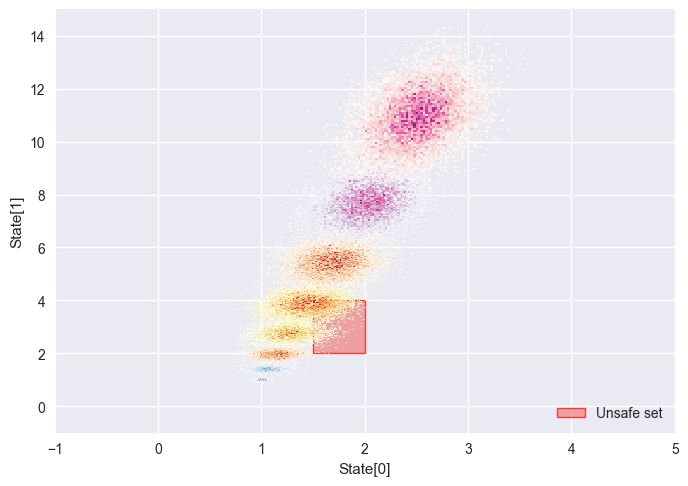

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_simulations = 10_000
mc_hitting_proba = []

fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):
    if t == 0:
        states = propag.getInitialState(mean_initial_state, var_initial_state, n_simulations)
    else:
        states = propag.stateOneStepEvolution(states, mean_noise, var_noise, METHOD, params)
    
    #Plot samples
    plt.hist2d(states[:, 0], states[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    #Compute hitting probability
    hitting_proba = barriers.hittingProbabilityMC(states, barrier)
    mc_hitting_proba.append(hitting_proba)

plt.legend(loc='lower right')

plt.xlim(-1, 5)
plt.ylim(-1, 15)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

##### Influence of noise variance

In [ ]:
# n_samples = 10_000

# min_proportion = 0.02
# min_size = 0.05
# n_refinements = 5

# tv_bounds = [0.0]
# gmm_hitting_proba = [0.0]

# variance_noise_options = [0.0001, 0.001, 0.01, 0.1, 1.0]

# for var_value in variance_noise_options:

#     var = np.array([var_value, var_value])

#     print('SIMULATION FOR VAR =  ', var_value)

#     for t in range(2):

#         print('TIME STEP', t+1)

#         if t == 0:
#             hat_gmm = [np.array([1.0]), np.array([mean_initial_state]), var_initial_state]
#         else:
#             means_gmm = propag.propagateSignatures(signatures, METHOD, params)
#             hat_gmm = [double_hat_proba, means_gmm, var_noise]


#         samples = propag.sampleFromGMM(n_samples, hat_gmm[0], hat_gmm[1], hat_gmm[2])
#         plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

#         if t < n_steps_ahead:

#             vertice_lower, vertice_upper = grid.findMinMaxPoints(samples)

#             hpr = np.array([vertice_lower, vertice_upper])

#             outer_signature = grid.computeOuterPoint(hpr)

#             regions = np.array(grid.subdivideRegion(hpr, samples, min_proportion, min_size))
#             print('Number of regions: ', len(regions))

#             signatures = grid.placeSignatures(regions)

#             double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])

#             regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)

#             tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var, METHOD, params)

#             for r in range(n_refinements):

#                 regions, signatures = grid.refineRegions(regions, signatures, contributions, 1e-7)
#                 regions = regions[:-1]
#                 signatures = signatures[:-1]
#                 double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
#                 regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
#                 print('Number of regions: ', len(regions))

#                 tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var, METHOD, params)

#             tv_bounds.append(tv_bound)

##### TV bounds

In [ ]:
n_samples = 10_000

min_proportion = 0.01
min_size = [40, 40, 40, 40, 40, 40, 400, 450, 450, 450]
n_refinements = 0

tv_bounds = [0.0]
gmm_hitting_proba = [0.0]


fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):

    if t == 0:
        hat_gmm = [np.array([1.0]), np.array([mean_initial_state]), var_initial_state]
    else:
        means_gmm = propag.propagateSignatures(signatures, METHOD, params)
        hat_gmm = [double_hat_proba, means_gmm, var_noise]

        #Compute hitting probability
        proba_barrier = proba.gmmProbabilityMassInsideRegion(double_hat_proba, means_gmm, var_noise, barrier)
        gmm_hitting_proba.append(proba_barrier)


    samples = propag.sampleFromGMM(n_samples, hat_gmm[0], hat_gmm[1], hat_gmm[2])
    plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    if t < n_steps_ahead:

        vertice_lower, vertice_upper = grid.findMinMaxPoints(samples)

        hpr = np.array([vertice_lower, vertice_upper])

        outer_signature = grid.computeOuterPoint(hpr)

        regions = np.array(grid.subdivideRegionUniformly(hpr, min_size[t]))
        print('Number of regions: ', len(regions))

        signatures = grid.placeSignatures(regions)

        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])

        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)

        tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)

        for r in range(n_refinements):

            regions, signatures = grid.refineRegions(regions, signatures, contributions, 1e-7)
            regions = regions[:-1]
            signatures = signatures[:-1]
            double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
            regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
            print('Number of regions: ', len(regions))

            tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)

        tv_bounds.append(tv_bound)
    

plt.legend(loc='lower right')

plt.xlim(-1, 5)
plt.ylim(-1, 15)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

Number of regions:  84100
Function 'computeSignatureProbabilitiesInParallel' executed in 1.1064s
TV bound at propag step: 0.005726348252880697
2.526615357667594e-15
Number of regions:  144400
Function 'computeSignatureProbabilitiesInParallel' executed in 924.2708s
TV bound at propag step: 0.009520391943642908
0.004198234639368274
Number of regions:  144400
Function 'computeSignatureProbabilitiesInParallel' executed in 1585.5139s
TV bound at propag step: 0.014447350047830959
0.10304230592867748
Number of regions:  144400
Function 'computeSignatureProbabilitiesInParallel' executed in 1957.6440s
TV bound at propag step: 0.02162539437796624
0.23703050718125906
Number of regions:  144400
Function 'computeSignatureProbabilitiesInParallel' executed in 2395.7824s
TV bound at propag step: 0.031836642222662456
0.00022836797045971293
Number of regions:  144400
Function 'computeSignatureProbabilitiesInParallel' executed in 1995.4785s
TV bound at propag step: 0.04500472937566466
0.0
Number of regio

##### TV contribution per region

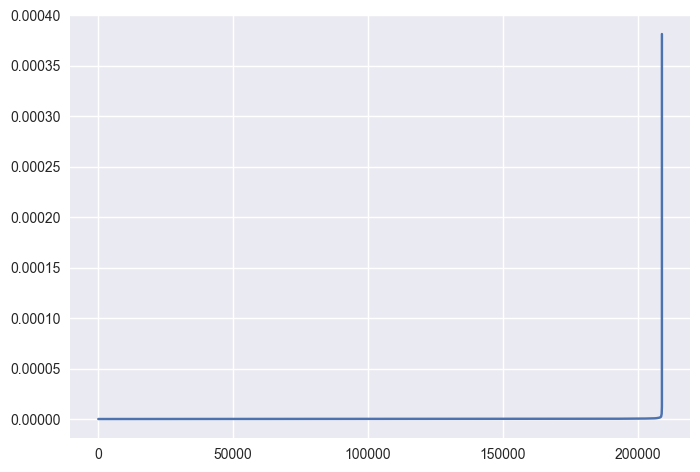

In [ ]:
contributions = np.array(contributions)
contributions = np.sort(contributions)
plt.plot(contributions)

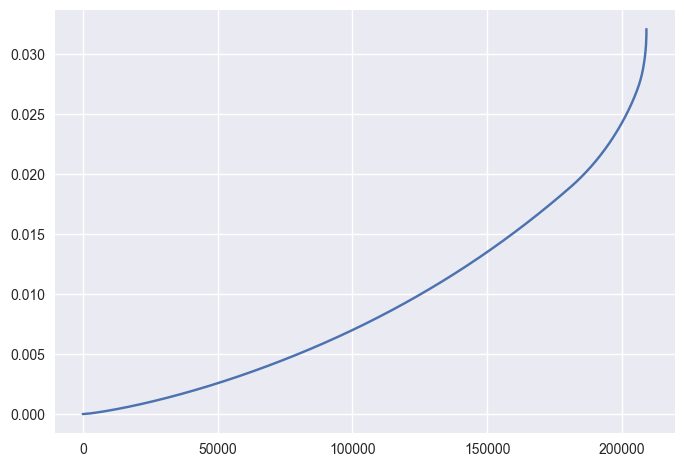

In [ ]:
plt.plot(np.cumsum(contributions))

In [ ]:
import matplotlib.pyplot as plt

def draw_square(x_min, y_min, x_max, y_max):
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='blue')

def plot_regions(regions):
    for region in regions:
        x_min, y_min = region[0]
        x_max, y_max = region[1]
        draw_square(x_min, y_min, x_max, y_max)
    plt.xlabel('State[0]')
    plt.ylabel('State[1]')
    plt.grid(True)
    plt.axis('equal')  # Set equal aspect ratio
    plt.show()

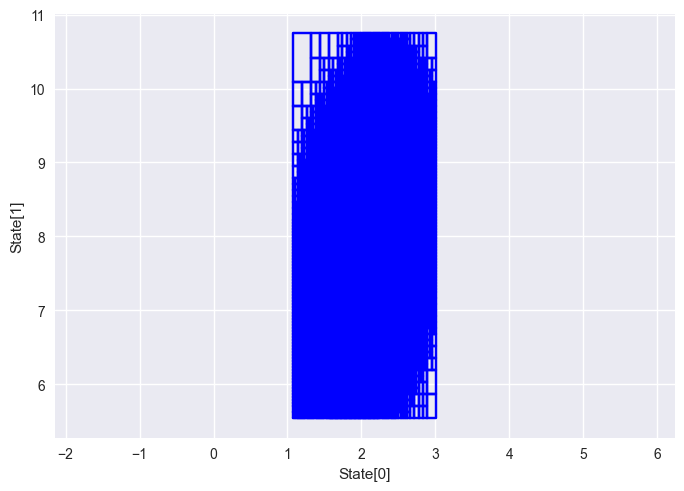

In [ ]:
plot_regions(regions)

##### Compare hitting probabilities

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_4716\1569244730.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


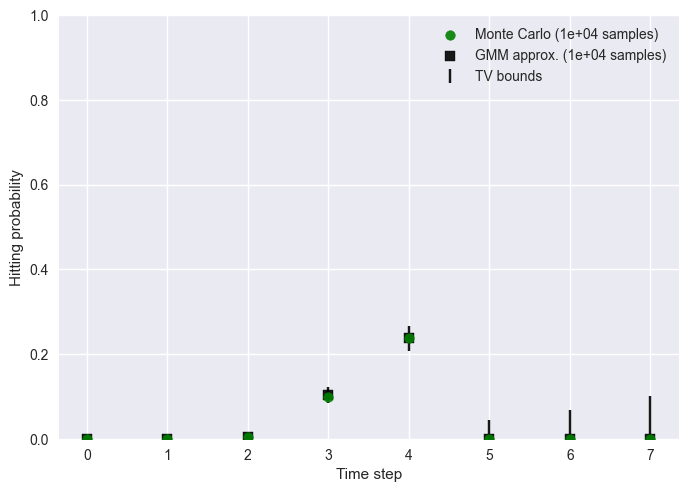

In [ ]:
#Compute TV bounds
tv_bounds_cumul = np.cumsum(tv_bounds)

plt.style.use("seaborn")

# Plotting
plt.scatter(range(len(mc_hitting_proba)), mc_hitting_proba, color='green', alpha = 0.9, label = f'Monte Carlo ({n_simulations:.0e} samples)', zorder=3)
plt.scatter(range(len(gmm_hitting_proba)), gmm_hitting_proba, color='black', alpha = 0.9, marker='s', label = f'GMM approx. ({n_samples:.0e} samples)', zorder=2)

# Adding error bars for gmm_probas
plt.errorbar(range(len(gmm_hitting_proba)), gmm_hitting_proba, yerr = tv_bounds_cumul, fmt='none', color='black', alpha = 0.9, capsize=5, label='TV bounds', zorder=1)

plt.ylim(0, 1)
plt.xticks(range(len(mc_hitting_proba)))

plt.xlabel('Time step')
plt.ylabel('Hitting probability')
plt.legend()
plt.show()

##### TV bounds

In [ ]:
tv_bounds_cumul

array([0.        , 0.00391372, 0.00997545, 0.01811119, 0.02923243,
       0.0447221 , 0.06779978, 0.09990701])